## NLP - Training Notebook

### We get the development target instances and add the short description (abstract) to each city

In [8]:
import pandas as pd
import numpy as np
from helper_functions import (discretize_target, get_short_descriptions, BIN_LABELS,
                              BIN_LABELS_TEXT, BINS, evaluate, words_analyser, get_upsampling, cross_validate)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from dbpedia_common import TARGET_DEV_CSV
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

target_dev_df = pd.read_csv('../' + TARGET_DEV_CSV)
short_abstracts = get_short_descriptions() # Parsing and loading descriptions (abstracts) of all cities

train_df = target_dev_df.copy()
train_df['target'] = discretize_target(train_df, BIN_LABELS, BINS)
train_df['description'] = train_df['subject'].map(short_abstracts)
# There are 9 instances with NO descriptions
train_df = train_df.drop(train_df[train_df.description.isnull()].index).reset_index(drop=True) 

* <b>Split the dataset in 8 bins penalizing more the errors in smaller cities.</b> 
* <b>Create stratified validation set to be used to test models</b>

<Figure size 432x288 with 0 Axes>

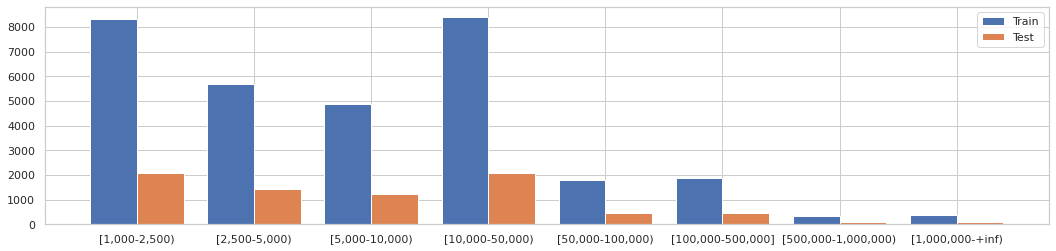

In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(train_df, train_df['target']))

train_all = train_df.loc[train_index]
train_X, train_y = train_all.drop(columns=['subject', 'target']), train_df.loc[train_index, 'target']
test_all = train_df.loc[test_index]
test_X, test_y = test_all.drop(columns=['subject', 'target']), train_df.loc[test_index, 'target']

plt.subplots_adjust()
plt.figure(figsize = (18,4))
plt.bar(BIN_LABELS_TEXT, train_y.value_counts().sort_index().values, align='edge', width=-0.4)
plt.bar(BIN_LABELS_TEXT, test_y.value_counts().sort_index().values, align='edge', width=0.4)
plt.legend(['Train', 'Test'], loc=1)

### A custom analyser function is being used:
 * Stems with SnowballStemmer
 * Applies lowercase
 * Removes punctuation
 * 1 and 2 ngrams
 * Removes stopwords
 * Adds custom tokens for numbers
 * Go to <b>population_dbpedia2020/nlp/helper_functions#words_analyser for more information</b>

### Best model is an stacking of Logistic Regression and SGD with modified_huber loss
* <b> Quadratic Kappa Score: 0.88 </b>
* <b> F1 score Micro: 0.74 </b>
* <b> F1 score Macro: 0.69 </b>

0    2040
3    1933
1    1362
2    1210
5     617
4     590
7      98
6      75
dtype: int64
Quadratic Kappa Score: 0.88
F1 score Micro: 0.73
F1 score Macro: 0.69
***Train***
Quadratic Kappa Score: 0.9
F1 score Micro: 0.79
F1 score Macro: 0.8


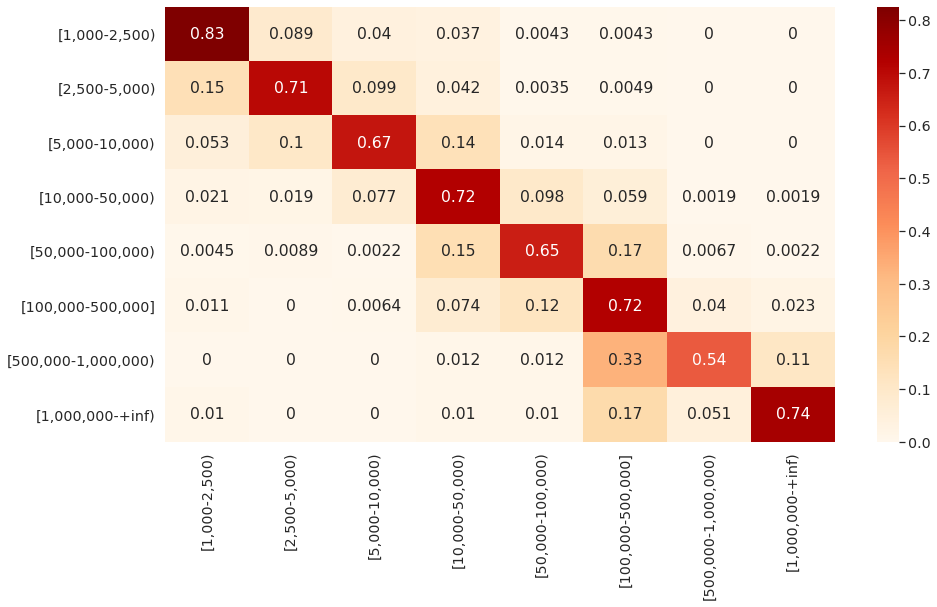

In [10]:
model = StackingClassifier(
            estimators=[
               ('modified_huber_SGD', SGDClassifier(loss="modified_huber", alpha=0.002, penalty="l2", max_iter=10000)),
               ('LogisticRegression', LogisticRegression(max_iter=10000, C=0.1, class_weight='balanced'))
            ],
            final_estimator=LogisticRegression(max_iter=10000, C=0.1, class_weight='balanced'))

stem_vectorizer = CountVectorizer(analyzer=words_analyser, min_df=3)
tfidf_transf = TfidfTransformer()
word_count_vector = stem_vectorizer.fit_transform(train_all.description)
tfidf_vector = tfidf_transf.fit_transform(word_count_vector)

X_train, y_train = get_upsampling(train_all, count_threshold=8000, tfidf_vector=tfidf_vector)

model.fit(X_train, y_train)
x_test_transformed = tfidf_transf.transform(stem_vectorizer.transform(test_X.description))
stacking_pred = model.predict(x_test_transformed)
evaluate(stacking_pred, test_y)

evaluate(model.predict(tfidf_vector), train_all.target, plot=False)

### Let's see the worst errors. 
* <b>I think we could improve our results with a better punctuation treatment (instead of remove everything at once)</b>
* <b> We could also generate tokens for similar (and very importan) words like: Census, population and inhabitants)
* <b> We might also try embeddings </b>

In [36]:
error_analyser = test_y.rename('target').astype(int).to_frame()
error_analyser['description'] = test_X.description
error_analyser['prediction'] = stacking_pred
error_analyser['abs_diff'] = (error_analyser.target - error_analyser.prediction).abs()
worst_errors = error_analyser[error_analyser.abs_diff > 0].sort_values('abs_diff', ascending=False)
for description in worst_errors.description.head(5).values:
    print(description)
#     print(list(words_analyser(description)))  # To see the tokens we generate from text
    print('-'*80)
    

"Kishoreganj (Bengali: কিশোরগঞ্জ) is a district in Dhaka Division of Bangladesh. Earlier it was a Mohkuma (মহকুমা) under the Mymensingh district. Kishorganj was made a separate district due to Mymensingh dominion suppression. So to suppress Mymensingh, Greater Mymensingh was separate from their 7 out of 6 upazila Kishorgonj, Tangail, Sherpur, Jamalpur, Netrokona( Presently known as District). from Mymensingh. The district consists of 8 municipalities, 13 upazilas, 105 union parishads, 39 wards, 145 mahallas, 946 mouzas and 1775 villages."@en
--------------------------------------------------------------------------------
"Trieste ( tree-EST, Italian: [triˈɛste] (); Slovene: Trst [tə́ɾst]) is a city and a seaport in northeastern Italy. It is situated towards the end of a narrow strip of Italian territory lying between the Adriatic Sea and Slovenia, which lies approximately 10–15 km (6.2–9.3 mi) south and east of the city. Croatia is some 30 km (19 mi) to the south."@en
-----------------

#### I tried other models that gave worse results:
    * Multinomial NB: Quadratic Kappa Score: 0.81
    * SVM: Quadratic Kappa Score: 0.8
    * LGBM: Quadratic Kappa Score: 0.81

### Cross validation

In [9]:
models = [
    MultinomialNB(),
    SGDClassifier(loss="modified_huber", alpha=0.002, penalty="l2", max_iter=10000),
    LogisticRegression(max_iter=10000, C=0.1, class_weight='balanced'),
]

for model in models:
    cross_validate(model, train_df, upsample=True, log=True)

MultinomialNB(): Quadratic Kappa Score: 0.81
MultinomialNB(): Quadratic Kappa Score: 0.8
MultinomialNB(): Quadratic Kappa Score: 0.8
MultinomialNB(): Quadratic Kappa Score: 0.8
MultinomialNB(): Quadratic Kappa Score: 0.8
***************************************
MultinomialNB()
Quadratic Kappa Score CV 5: 0.8
F1 score overall CV 5: 0.6
F1 Score CV 5: 0.52
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000): Quadratic Kappa Score: 0.87
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000): Quadratic Kappa Score: 0.86
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000): Quadratic Kappa Score: 0.87
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000): Quadratic Kappa Score: 0.87
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000): Quadratic Kappa Score: 0.87
***************************************
SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=10000)
Quadratic Kappa Score CV 5: 0.87
F1 score overall CV 5: 0.74
F1